In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
# from skymapper import Map, projection

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, scales

from deepsphere.healpy_layers import HealpySmoothing

24-05-10 06:41:37   imports.py INF   Setting up healpy to run on 32 CPUs 
24-05-10 06:41:37   imports.py INF   Setting up healpy to run on 32 CPUs 


In [3]:
with_lensing=True
with_clustering=True
apply_smoothing=True

# v4 of the pipeline (multiple poisson noise realizations)

In [4]:
# # tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/large_scales/tfrecords/grid/DESy3_grid_249.tfrecord"
# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v4/large_scales/tfrecords/grid/DESy3_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3linear_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3quadratic_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/tfrecords/grid/DESy3_grid_000.tfrecord"
# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/debug/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "_linear"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/quadratic_bias/debug/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# # filename_suffix = "_quadratic"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/stochasticity/tfrecords/grid/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/stochasticity.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "_stochasticity"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3grf_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# # params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "grf"

# tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/tfrecords/grid/DESy3_grid_050.tfrecord"
# # tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/DESy3_grid_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = ""


# v7

In [5]:
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v7/linear_bias/tfrecords/grid/DESy3_grid_0134.tfrecord"

# conf = "//global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v7/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "v7"

# v8

In [6]:
# tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v8/debug/full/DESy3_grid_0001.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/tfrecords/grid/DESy3_grid_dmb_0057.tfrecord"
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/grid/DESy3_grid_dmb_0001.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/grid/DESy3_grid_dmb_1792.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/tfrecords/grid/DESy3_grid_dmb_1792.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml"
conf = files.load_config(conf)
# conf = "/cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml"
params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "_v8_no_noise"
# filename_suffix = "_v8_noisy_naive"
# filename_suffix = "_v8_noisy_10p"
filename_suffix = "_v8_noisy_1p"
# filename_suffix = "_v8_smoothed_hp"
# filename_suffix = "_v8_smoothed_30_arcmin"
# filename_suffix = "_v8_smoothed_5_sigma"
# filename_suffix = "_v8_non_smoothed"

In [7]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
)

24-05-10 06:41:38     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-10 06:41:38     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


In [8]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

### smoothing

In [9]:
dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v8/combined/linear_bias/dlss_config.yaml"
dlss_conf = input_output.read_yaml(dlss_conf)
            
mask_dict = files.get_tomo_dv_masks(conf)
    
if with_lensing and with_clustering:
    mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)
elif with_lensing and not with_clustering:
    mask = mask_dict["metacal"]
elif not with_lensing and with_clustering:
    mask = mask_dict["maglim"]
else:
    raise ValueError("At least one of with_lensing and with_clustering must be True")
    
mask = mask.numpy()

fwhm = []
if with_lensing:
    fwhm += dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"]
if with_clustering:
    fwhm += dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]

# fwhm = [30] * n_z
    
smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "mask": mask,
    "fwhm": fwhm,
    "arcmin": dlss_conf["scale_cuts"]["arcmin"],
    # "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    "n_sigma_support": 5,
    # naive
    # "white_noise_sigma": [0.51520719, 0.35428238, 0.27699105, 0.26566648, 1.62299023, 0.81909851, 0.64732432, 0.73886103],
    # 10%
    # "white_noise_sigma": [0.39659172, 0.27256747, 0.21457003, 0.21277644, 1.09389987, 0.58061397, 0.46553319, 0.51377827],
    # 1%
    "white_noise_sigma": [0.12516133, 0.08745182, 0.05437602, 0.09995155, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
    "data_path": ".",
}

mask = mask.astype(bool)

smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-05-10 06:41:40     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma ListWrapper([0.12516133, 0.08745182, 0.05437602, 0.09995155, 0.26904975, 0.14492357, 0.11769442, 0.12976879]) to the smoothed map


### compare noise realizations to noiseless

In [10]:
noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        noise_indices=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

dvs_noisy = []
for dv, cosmo, index in noisy_grid_dset.take(n_noise):
    # apply smoothing
    if apply_smoothing:
        dv = smoothing_layer(dv)
        
        # hp_map = np.zeros((hp.nside2npix(n_side), dv.shape[-1]))
        # hp_map[data_vec_pix] = dv[0]             
        # hp_map, _ = scales.map_to_smoothed_map(
        #     hp_map, 
        #     n_side=n_side,
        #     l_min=[0]*n_z,
        #     theta_fwhm=fwhm,
        #     arcmin=dlss_conf["scale_cuts"]["arcmin"],
        #     nest=True
        # )        
        # dv = hp_map[data_vec_pix]
        # dv = dv[np.newaxis]
        
    dvs_noisy.append(dv)
    
dvs_noisy = np.concatenate(dvs_noisy, axis=0)
print(dvs_noisy.shape)

24-05-10 06:41:45 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-10 06:41:45 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-05-10 06:41:45 grid_pipelin INF   Including noise_indices = [0, 1, 2] 
24-05-10 06:41:45 grid_pipelin INF   Interleaving with n_readers = 1 
24-05-10 06:41:45 grid_pipelin INF   Batching into 1 elements locally 
24-05-10 06:41:46 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [11]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

gnoms = np.zeros((len(dvs_noisy), x_pix, y_pix, n_z))

for i_n in range(len(dvs_noisy)):
    for i_z in range(n_z):
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

        gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
        gnoms[i_n, ..., i_z] = gnom

gnoms = np.ma.masked_where(gnoms==0, gnoms)

In [12]:
# reso = 600

# gnoms = np.zeros((len(dvs_noisy), reso, reso, n_z))

# for i_n in range(len(dvs_noisy)):
#     for i_z in range(n_z):
#         hp_map = np.full(n_pix, hp.UNSEEN)
#         hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

#         gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=1, xsize=reso, ysize=reso, return_projected_map=True, no_plot=True)
#         gnoms[i_n, ..., i_z] = gnom

# gnoms = np.ma.masked_where(gnoms==0, gnoms)

### raw maps

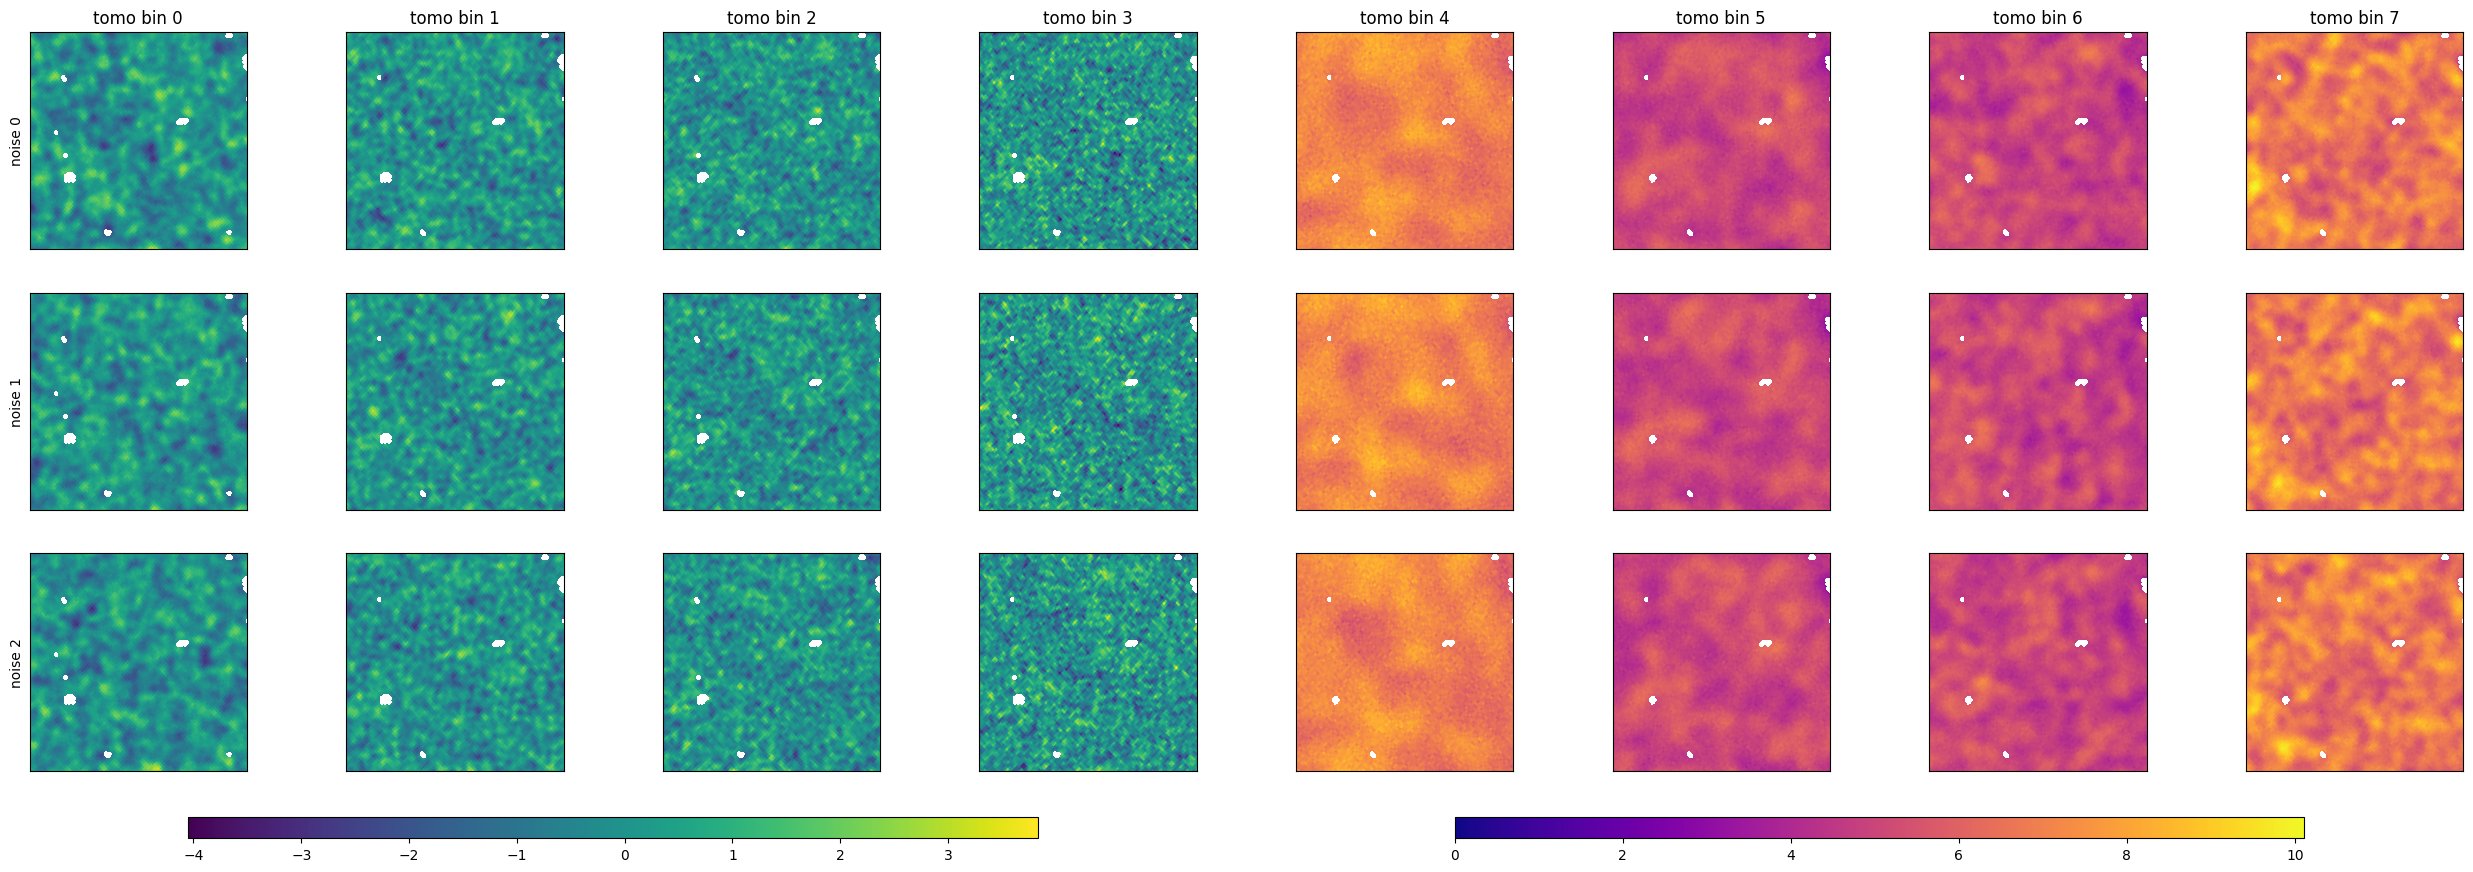

In [13]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*n_noise), nrows=n_noise, ncols=n_z)

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            
            # vmin = -4
            # vmax = 5

            cmap = "plasma"

        gnom = gnoms[i_n, ..., i_z]

        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n}")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 1:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

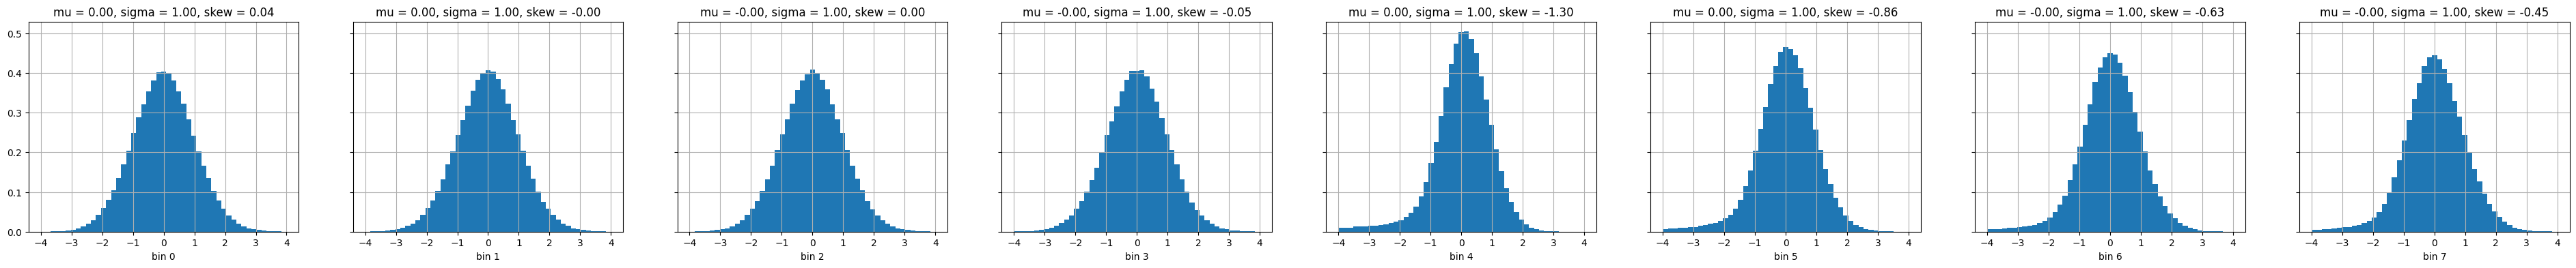

In [14]:
fig, ax = plt.subplots(figsize=(6*n_z, 4), ncols=n_z, sharex=True, sharey=True)

i_noise = 0

for i in range(n_z):
    # multiple noise realizations
    # dv_noisy = dvs_noisy[...,i]
    # dv_noisy = dv_noisy.ravel()

    # single noise realization
    dv_noisy = dvs_noisy[i_noise,:,i]
    dv_noisy = dv_noisy[mask[:,i]]
    
    dv_noisy = (dv_noisy - np.mean(dv_noisy))/np.std(dv_noisy)
    
    # print(np.mean(dv_noisy), np.std(dv_noisy), skew(dv_noisy), kurtosis(dv_noisy))
    
    ax[i].hist(dv_noisy, np.linspace(-4, 4, 50), density=True)
    # ax[i].hist(dv_noisy[dv_noisy!=0], np.linspace(-4, 4, 50), density=True)

    ax[i].set(title=f"mu = {np.mean(dv_noisy):.2f}, sigma = {np.std(dv_noisy):.2f}, skew = {skew(dv_noisy):.2f}", xlabel=f"bin {i}")
    ax[i].grid(True)
    
fig.savefig("plots/clustering_hist" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### differences to noise 0

In [15]:
# fig, ax = plt.subplots(figsize=(4*n_z, 4*(n_noise - 1)), nrows=n_noise - 1, ncols=n_z)

# for i_n in range(n_noise - 1):
#     for i_z in range(n_z):
#         # lensing
#         if i_z < n_z_metacal:
#             vmin = wl_min
#             vmax = wl_max
#             cmap = "viridis"

#         # clustering
#         else:
#             vmin = gc_min
#             vmax = gc_max
#             cmap = "plasma"

#         gnom = gnoms[i_n+1, ..., i_z] - gnoms[0, ..., i_z]
#         im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

#         ax[i_n, i_z].set_xticks([])
#         ax[i_n, i_z].set_yticks([])
#         ax[i_n, i_z].set_aspect("equal")
        
#         if i_z == 0:
#             ax[i_n, i_z].set(ylabel=f"noise {i_n+1} - noise 0")
            
#         if i_n == 0:
#             ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
#         if i_n == n_noise - 2:
#             if i_z == 0:
#                 fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#             if i_z == 4:
#                 fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
# fig.savefig("plots/gnom_noise_diff" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### mollview

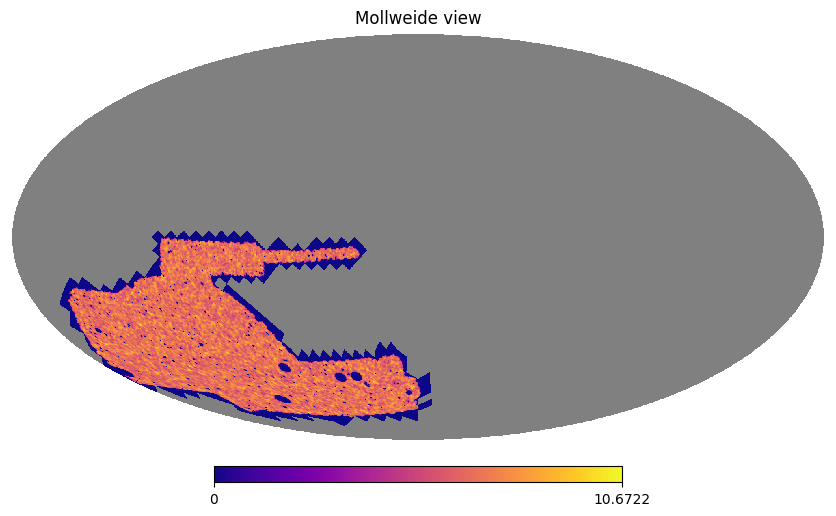

In [16]:
i_noise = 0
i_z = 7

hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

hp.mollview(hp_map, nest=True, cmap="plasma", xsize=2000)
plt.savefig(f"plots/moll_map_bin{i_z}" + filename_suffix + ".png", bbox_inches="tight", dpi=500)

In [17]:
# wl_min = np.array(dvs_noisy[...,:n_z_metacal]).min()
# wl_max = np.array(dvs_noisy[...,:n_z_metacal]).max()

# gc_min = np.array(dvs_noisy[...,n_z_metacal:]).min()
# gc_max = np.array(dvs_noisy[...,n_z_metacal:]).max()

# plt.figure(figsize=(4*n_z,2*n_noise))

# i_subplot = 1
# for i_n  in range(n_noise):
#     for i_z in range(n_z):
#         # lensing
#         if i_z < n_z_metacal:
#             vmin = wl_min
#             vmax = wl_max
#             cmap = "viridis"

#         # clustering
#         else:
#             vmin = gc_min
#             vmax = gc_max
#             cmap = "plasma"
            
#         if i_n == 0:
#             title = f"tomo bin {i_z}"
#         else:
#             title = ""

#         hp_map = np.full(n_pix, hp.UNSEEN)
#         hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]
        
#         hp.mollview(hp_map, nest=True, cmap=cmap, sub=(n_noise,n_z,i_subplot), xsize=2000, title=title, min=vmin, max=vmax)
#         i_subplot += 1

# plt.savefig("plots/moll_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=500)

# noise index selection

In [18]:
# noise_indices = 3
# noise_indices = [0, 2]
# n_noise = noise_indices if isinstance(noise_indices, int) else len(noise_indices)

# temp_dset = grid_pipe.get_dset(
#         tfr_pattern=tfr_pattern,
#         noise_indices=noise_indices,
#         local_batch_size=1,
#         n_readers=1,
#         n_prefetch=0,
# )

# i_z = 5
# for dv, cosmo, index in temp_dset.take(3*n_noise):
#     print(index[2])

#     hp_map = np.zeros(n_pix)
#     hp_map[data_vec_pix] = dv[0,:,i_z]
    
#     # smoothing to reduce the effect of noise, since it's always included for the grip pipe
#     hp_map = hp.smoothing(hp_map, fwhm=0.01, nest=True)
    
#     hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=False, no_plot=False)
